In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy import linalg
%matplotlib inline
%autosave 30

Autosaving every 30 seconds


# Modélisation 
#### on étude le problem pendule-chariot en utilisant le methode de contrôle numériquement. 

In [2]:
a,b,c,d = 0,8,4,0  
m = a+1.
M = b+1.
l = c+1.
alpha =1/(1.+d)
g = 9.8
x0 = 1
theta0 = np.pi/6

#### on utilise methode de lagrangien pour analyse cette problem.
$$ T = \frac{1}{2}M\dot{x}^2 + \frac{1}{2}m[ (-l\dot{\theta}\cos\theta+\dot{x})\overrightarrow{e_x} - l\dot{\theta}\sin\theta\overrightarrow{e_y}]^2$$
$$ U = -mgl\sin\theta$$
$$ L = T - U $$
#### Après lagrangien, on simplifie les équations :
$$(m+M)\ddot{x} - ml\ddot{\theta}\cos\theta = F - ml\dot{\theta}^2\sin\theta$$
$$-\cos\theta\ddot{x} + l\ddot{\theta} = g\sin\theta$$
#### linéralisation :
$$\ddot{x} = \frac{m}{M}g\theta + \frac{F}{M}$$
$$\ddot{\theta} = \frac{m+M}{M}\frac{g}{l}\theta + \frac{F}{lm}$$

In [3]:
A = np.array([[0,0,1,0],[0,0,0,1],[0,m*g/M,0,0],[0,(M+m)*g/(M*l),0,0]])
B = np.array([[0],[0],[1/M],[1/(l*M)]]) 

In [4]:
A,B

(array([[ 0.        ,  0.        ,  1.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  1.        ],
        [ 0.        ,  1.08888889,  0.        ,  0.        ],
        [ 0.        ,  2.17777778,  0.        ,  0.        ]]),
 array([[ 0.        ],
        [ 0.        ],
        [ 0.11111111],
        [ 0.02222222]]))

In [5]:
vp,VP = np.linalg.eig(A)
vp

array([ 0.        ,  0.        ,  1.47572957, -1.47572957])

# Analyse

In [6]:
def model_nonline(y,t):
    global A,B
    dydt = np.zeros(4)  # x theta x. theta.
    dydt[0] = y[2]
    dydt[1] = y[3]
    dydt[2] = 1    #beaucoup de terms
    dydt[3] = 2    #beaucoup de terms
    return dydt

In [7]:
def model_line(y,t,A):
    return np.dot(A,y)

In [8]:
def model_line_contro(y,t,F):
    global A,B
    return np.dot(A,y)+np.dot(B,F)

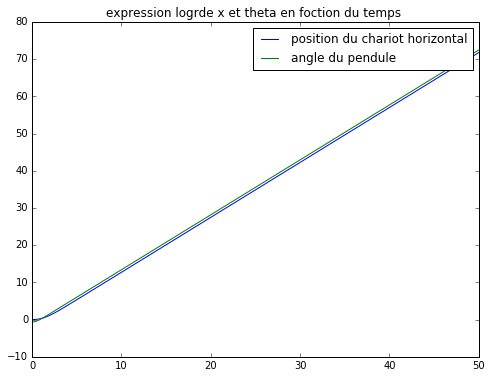

In [9]:
t = np.linspace(0,50,num=10000)
y0 = [x0,theta0,0,0]
y = odeint(model_line,y0,t,args=(A,))
#y_line_control = odeint(model_line,y0,t)
#plt.plot(t,y[:,0])
plt.figure(figsize = (8,6))
plt.plot(t,np.log(y[:,0]))
plt.plot(t,np.log(y[:,1])) 
plt.title('expression logrde x et theta en foction du temps ')
plt.legend(['position du chariot horizontal','angle du pendule '])
plt.show()

In [10]:
num = 10000
pente = (np.log(y[3*num/4,0])-np.log(y[num/4,0]))/(t[3*num/4]-t[num/4])
pente,vp[2]

(1.4757296016500585, 1.4757295747452437)

### controle optimal par retour d'etat
$$\dot{Y} = AY + Bu$$
### control u minimisant un cout qui est : 
$$J(u) = \frac{1}{2}\int^{\infty}_0(Y^tQY + u^tRu)dt$$
### minimisant le cout en utilisant dérivation :
$$u = -GY$$
$$G = R^{-1}B^tK$$
#### K est la solution de :
$$PA + A^tP - PBR^{-1}B^tP + Q = 0$$
Définir les différentes matrices du système, et écrire l’équation de Ricatti permettant de déterminer la matrice adjoint P du système et en déduire le contrôle optimal u sous la forme u = −K Y

$$J = \int^{\infty}_0(\theta^2 + x^2 + \alpha u^2) dt$$

(4, 4)
[-1.47571469+0.00266174j -1.47571469-0.00266174j -0.12584580+0.12564294j
 -0.12584580-0.12564294j]


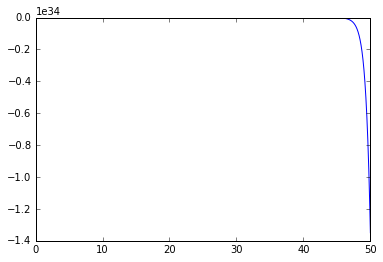

In [11]:
Q = np.array([[1,0,0,0],[0,1,0,0],[0,0,0,0],[0,0,0,0]])
R = alpha
K = linalg.solve_continuous_are(A,B,Q,R)
# print B.shape,B.dtype
print K.shape
# A1 = np.array([1/alpha])
# A2 = np.transpose(B)
G = (1./alpha)*np.dot(B.T,K)
vp,VP = np.linalg.eig(A-np.dot(B,G))
print vp
u = -np.dot(y,G.T)
# print np.shape(u)
plt.plot(t,u)

#### on plot la position du chariot par le point d'original et l'angle du pendule 

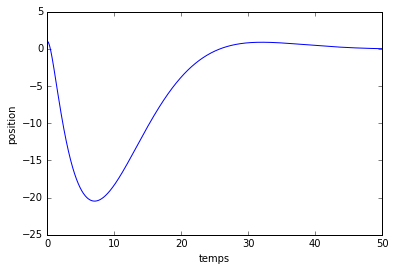

In [12]:
H = A-np.dot(B,G)
y_control = odeint(model_line,y0,t,args=(H,))
plt.figure()
plt.plot(t,y_control[:,0])
plt.xlabel('temps')
plt.ylabel('position')
plt.show()

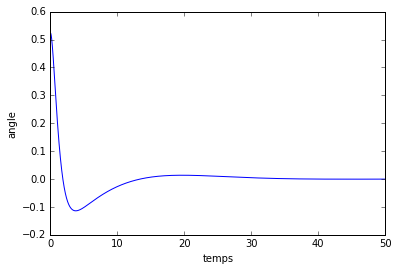

In [13]:
plt.figure()
plt.plot(t,y_control[:,1])
plt.xlabel('temps')
plt.ylabel('angle')
plt.show()

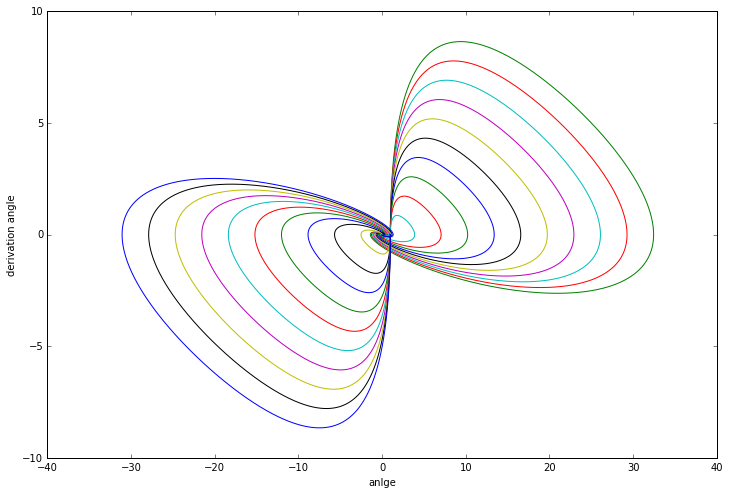

In [14]:
plt.figure(figsize=(12,8))
plt.plot([0.],[0.],'o')
for theta0 in np.linspace(-np.pi/4,np.pi/4,21):
    y0 = [x0,theta0,0,0]
    y_control = odeint(model_line,y0,t,args=(H,))
    plt.plot(y_control[:,0],y_control[:,2])
plt.xlabel('anlge')
plt.ylabel('derivation angle')
plt.show()

# Conclusion
#### Dans ce séance, on étude le control d'appliqué pour trouver résultat stable. On utilise linéralisation pour evaluer ce problèm, je suis un peu incertain sur le control u(t), parce qu'il est très grande. Et je ne trouve pas le solution qui est sous la form sinusoïdale.